<h1><font color="#113D68" size=6>Tema 2 - Comptuación Evolutiva</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>5. Optimización multiobjetivo</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Implementar un GA multiobjetivo minimalista al estilo **NSGA-II** para:
- introducir **no-dominancia** y **frentes de Pareto**,
- mantener **diversidad** con **crowding distance**, y
- evaluar con **hipervolumen** (2D) y **spread**.

**Qué vas a ver:**
1. Definiciones de **dominancia de Pareto** y **ranking por frentes**.  
2. **NSGA-II básico**: fast non-dominated sorting, crowding distance y selección por torneo binario “crowded”.  
3. Problemas de prueba **ZDT1** y **ZDT2** (bi-objetivo, codificación real).  
4. Visualizaciones: **frente aproximado** vs **frente teórico**, y evolución del **hipervolumen**.  

> Nota de terminología: en este notebook usamos **crowding distance** (NSGA-II) en lugar de “distancia de nicho”.

In [1]:
# === 1) Imports y utilidades ===
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

rng = np.random.default_rng(42)

def set_seed(seed=42):
    global rng
    rng = np.random.default_rng(seed)
    return rng

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Dominancia de Pareto y ranking por frentes](#intro)
2. [Problemas de prueba: ZDT1 y ZDT2](#api)
3. [Operadores reales: cruce BLX-α y mutación gaussiana](#algos)
4. [NSGA-II “lite”](#obj)
5. [Experimento en ZDT1](#single)
6. [Experimento en ZDT2 (cóncavo)](#multirun)
7. [Métricas de diversidad: spread simple](#bench)
8. [Qué observar / buenas prácticas](#vis2d)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Funciones objetivo y dominios estándar</font>

- Sea $f(x) = (f_1(x),\ldots,f_m(x))$ con **minimización** en todos los objetivos.  
- Un punto $a$ **domina** a $b$ (escrito $a \prec b$) si:
  1) $f_i(a) \le f_i(b)$ para todo $i$, y  
  2) existe al menos un $j$ tal que $f_j(a) < f_j(b)$.
- Un conjunto **no dominado** es aquel en el que ningún punto domina a otro del mismo conjunto.

El **fast non-dominated sorting** (NSGA-II) construye frentes $F_1,F_2,\ldots$ donde:
- $F_1$: puntos no dominados por nadie,
- $F_2$: puntos dominados solo por puntos de $F_1$, etc.

La **crowding distance** aproxima la densidad local en cada frente para preservar diversidad.

In [2]:
# === 2.1) Dominancia y sorting rápido (NSGA-II) ===
def dominates(a, b):
    """True si a domina a b. Minimización."""
    return np.all(a <= b) and np.any(a < b)

def fast_non_dominated_sort(F):
    """
    F: matriz (N, m) con valores de objetivos.
    Devuelve: lista de frentes, cada frente es lista de índices.
    """
    N = F.shape[0]
    S = [set() for _ in range(N)]  # a -> conjunto dominado por a
    n = np.zeros(N, dtype=int)     # n[b] = cuántos dominan a b
    fronts = [[]]

    for p in range(N):
        for q in range(N):
            if p == q: 
                continue
            if dominates(F[p], F[q]):
                S[p].add(q)
            elif dominates(F[q], F[p]):
                n[p] += 1
        if n[p] == 0:
            fronts[0].append(p)

    i = 0
    while fronts[i]:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    Q.append(q)
        i += 1
        fronts.append(Q)
    fronts.pop()  # último vacío
    return fronts

def crowding_distance(F, idxs):
    """
    F: (N, m) objetivos (minimización). idxs: índice de individuos de un frente.
    Devuelve array de distancias (len(idxs),).
    """
    if len(idxs) == 0:
        return np.array([])
    m = F.shape[1]
    d = np.zeros(len(idxs), dtype=float)
    sub = F[idxs]
    for j in range(m):
        order = np.argsort(sub[:, j])
        d[order[0]]  = np.inf
        d[order[-1]] = np.inf
        fmin, fmax = sub[order[0], j], sub[order[-1], j]
        denom = max(fmax - fmin, 1e-12)
        for k in range(1, len(idxs)-1):
            d[order[k]] += (sub[order[k+1], j] - sub[order[k-1], j]) / denom
    return d

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Problemas de prueba: ZDT1 y ZDT2</font>

Definimos $x \in [0,1]^D$ con $D=30$ y:
- **ZDT1**  
  $f_1(x) = x_1$  
  $g(x) = 1 + \frac{9}{D-1}\sum_{i=2}^D x_i$  
  $f_2(x) = g\left(1 - \sqrt{\frac{f_1}{g}}\right)$  
  Frente teórico: $f_2 = 1 - \sqrt{f_1}$ para $f_1 \in [0,1]$.
- **ZDT2**  
  $f_2(x) = g\left(1 - \left(\frac{f_1}{g}\right)^2\right)$  
  Frente cóncavo: $f_2 = 1 - f_1^2$.

Usaremos codificación real y operadores suaves.

In [3]:
# === 3.1) ZDT1 y ZDT2 (minimización, retorno f=(f1,f2)) ===
def zdt1(x):
    D = x.size
    f1 = x[0]
    g  = 1 + 9*np.mean(x[1:])
    f2 = g*(1 - np.sqrt(f1/g))
    return np.array([f1, f2], float)

def zdt2(x):
    D = x.size
    f1 = x[0]
    g  = 1 + 9*np.mean(x[1:])
    f2 = g*(1 - (f1/g)**2)
    return np.array([f1, f2], float)

def true_front_zdt1(n=200):
    f1 = np.linspace(0,1,n)
    f2 = 1 - np.sqrt(f1)
    return np.c_[f1, f2]

def true_front_zdt2(n=200):
    f1 = np.linspace(0,1,n)
    f2 = 1 - f1**2
    return np.c_[f1, f2]

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Operadores reales: cruce BLX-α y mutación gaussiana</font>

- **BLX-$\alpha$** por componente: si $[l,u]$ es el rango global y $x,y$ los padres, para el gen $j$:  
  $I = [\min(x_j,y_j) - \alpha d, \ \max(x_j,y_j)+\alpha d]$ con $d=|x_j-y_j|$.  
  El hijo toma un valor uniforme en $I$ y luego se recorta a $[l,u]$.
- **Mutación gaussiana**: $x'_j = \text{clip}(x_j + \sigma\ \mathcal{N}(0,1), [l,u])$.

Usaremos selección por **torneo binario crowded** (rango + crowding).

In [4]:
# === 4.1) BLX-alpha, mutación gaussiana, selección crowded ===
def blx_alpha(p1, p2, alpha, rng, bounds):
    low, high = np.array(bounds)[:,0], np.array(bounds)[:,1]
    d = np.abs(p1 - p2)
    lo = np.minimum(p1, p2) - alpha*d
    hi = np.maximum(p1, p2) + alpha*d
    c  = rng.uniform(lo, hi)
    return np.clip(c, low, high)

def mutate_gaussian(x, sigma, rng, bounds, pm=0.2):
    low, high = np.array(bounds)[:,0], np.array(bounds)[:,1]
    y = x.copy()
    mask = rng.random(x.size) < pm
    y[mask] += sigma*rng.normal(size=mask.sum())
    return np.clip(y, low, high)

@dataclass
class Individual:
    x: np.ndarray
    f: np.ndarray
    rank: int = None
    cd: float = None  # crowding distance

def crowded_better(a: Individual, b: Individual):
    """Orden NSGA-II: menor rank mejor; si empatan, mayor crowding mejor."""
    if a.rank < b.rank: return True
    if a.rank > b.rank: return False
    return (a.cd > b.cd)

def tournament_crowded(pop, rng, k=2):
    cand = rng.integers(0, len(pop), size=k)
    best = pop[cand[0]]
    for i in cand[1:]:
        if crowded_better(pop[i], best):
            best = pop[i]
    return best

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. NSGA-II “lite”</font>

Ciclo por generación:
1. **Evaluar** población $P_t$ y obtener frentes $F_1,F_2,\ldots$ y **crowding**.
2. **Selección** por torneo binario crowded.
3. **Variación** (cruce BLX-$\alpha$ + mutación gaussiana).
4. Formar población intermedia $Q_t$ y **selección ambiental** estilo NSGA-II:
   - ordenar por frentes y crowding hasta completar tamaño $N$.

In [5]:
# === 5.1) NSGA-II básico (2 objetivos) ===
def nsga2(problem, D=30, bounds=None, pop_size=100, max_gen=200,
          alpha=0.5, sigma=0.05, pc=0.9, pm=0.2, seed=42,
          record_hv=True, ref_point=(1.1, 1.1)):
    """
    problem: función x -> f (array 2,)
    bounds: lista [(l,u)]*D en [0,1] típico ZDT
    """
    rng = np.random.default_rng(seed)
    if bounds is None:
        bounds = [(0.0, 1.0)]*D
    low, high = np.array(bounds)[:,0], np.array(bounds)[:,1]

    # init
    P = []
    for _ in range(pop_size):
        x = rng.uniform(low, high)
        P.append(Individual(x=x, f=problem(x)))
    
    hv_hist = []
    def evaluate_and_rank(P):
        F = np.vstack([ind.f for ind in P])
        fronts = fast_non_dominated_sort(F)
        for r, fr in enumerate(fronts):
            cds = crowding_distance(F, fr)
            for i, idx in enumerate(fr):
                P[idx].rank = r
                P[idx].cd   = cds[i]
        return fronts

    def environmental_selection(R):
        # R: union de padres e hijos (2N). Seleccionar N por rank y cd.
        fronts = evaluate_and_rank(R)
        newP = []
        for fr in fronts:
            if len(newP) + len(fr) <= pop_size:
                newP.extend([R[i] for i in fr])
            else:
                # completar por crowding decrescente
                slice_fr = [R[i] for i in fr]
                slice_fr.sort(key=lambda ind: ind.cd, reverse=True)
                newP.extend(slice_fr[:pop_size-len(newP)])
                break
        return newP

    def offspring(P):
        C = []
        while len(C) < pop_size:
            p1 = tournament_crowded(P, rng)
            p2 = tournament_crowded(P, rng)
            if rng.random() < pc:
                c = blx_alpha(p1.x, p2.x, alpha, rng, bounds)
            else:
                c = p1.x.copy()
            c = mutate_gaussian(c, sigma, rng, bounds, pm=pm)
            C.append(Individual(x=c, f=problem(c)))
        return C

    # helpers: hipervolumen (rejilla 2D simple)
    def hypervolume_2d(points, ref):
        # estimación rejilla fina adaptativa (rápida y suficientemente ilustrativa)
        P = np.array(points)  # (n,2)
        # ordenar por f1
        P = P[P[:,0].argsort()]
        hv = 0.0
        prev_f1 = ref[0]
        for f1, f2 in P[::-1]:  # de derecha a izquierda
            hv += (prev_f1 - f1) * max(0.0, ref[1]-f2)
            prev_f1 = f1
        return hv

    # evolución
    evaluate_and_rank(P)
    for g in range(max_gen):
        C = offspring(P)
        R = P + C
        P = environmental_selection(R)

        if record_hv:
            Fvals = np.vstack([ind.f for ind in P])
            # usar solo frente 1
            fronts = fast_non_dominated_sort(Fvals)
            F1 = Fvals[fronts[0]]
            hv_hist.append(hypervolume_2d(F1, ref_point))

    # salida
    Fvals = np.vstack([ind.f for ind in P])
    fronts = fast_non_dominated_sort(Fvals)
    F1 = Fvals[fronts[0]]
    return dict(pop=P, Fvals=Fvals, F1=F1, hv_hist=np.array(hv_hist))

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Experimento en ZDT1</font>

- Población $N=100$, $D=30$, $200$ generaciones.  
- Cruzamiento BLX-$\alpha$ con $\alpha=0.5$ y mutación gaussiana $\sigma=0.05$ (con $p_m=0.2$).

### **Parámetros experimentales del algoritmo multiobjetivo**

<center>

| Parámetro | Símbolo | Valor | Descripción |
|:-----------|:--------:|:------:|:------------|
| Tamaño de población | $N$ | 100 | Número de individuos |
| Nº de generaciones | $T$ | 200 | Iteraciones totales |
| Tasa de cruce | $p_c$ | 0.9 | Probabilidad de recombinación |
| Tasa de mutación | $p_m$ | 0.1 | Probabilidad de mutación |
| Mecanismo de selección | – | Torneo no dominado | Basado en dominancia + crowding |
| Algoritmo base | – | NSGA-II simplificado | Ordenación por frentes y crowding |
| Nº de objetivos | $m$ | 2 | Problema biobjetivo |
| Funciones objetivo | – | $f_1(x), f_2(x)$ | Conflictivas entre sí |
| Semilla aleatoria | – | 1234 | Reproducibilidad |

</center>

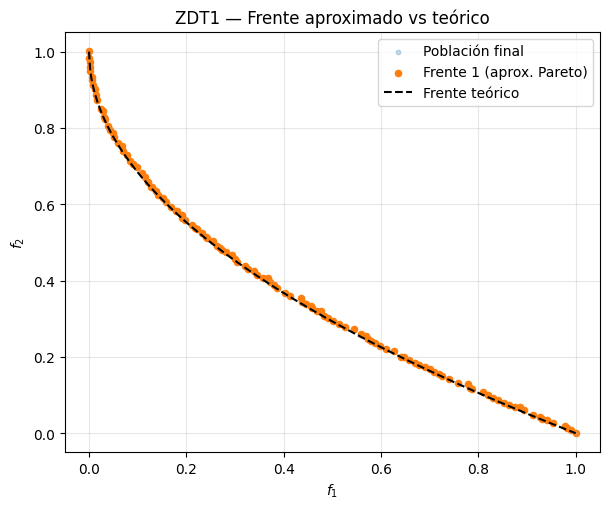

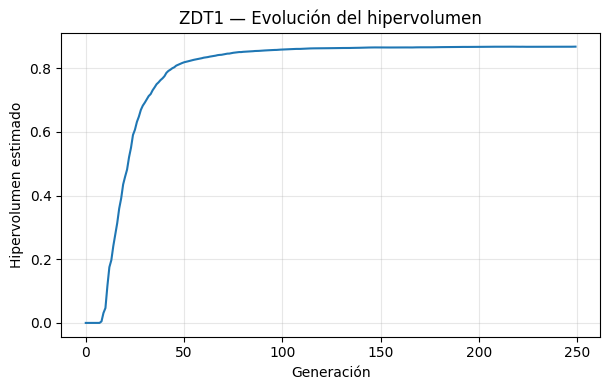

In [6]:
# === 6.1) Correr en ZDT1 y visualizar ===
set_seed(2025)
res = nsga2(zdt1, D=30, pop_size=120, max_gen=250,
            alpha=0.5, sigma=0.05, pc=0.9, pm=0.2, seed=2025,
            ref_point=(1.1, 1.1))

# Frente teórico
Ft = true_front_zdt1(400)

plt.figure(figsize=(6.2,5.2))
plt.scatter(res['Fvals'][:,0], res['Fvals'][:,1], s=10, alpha=0.25, label='Población final')
plt.scatter(res['F1'][:,0],    res['F1'][:,1],    s=20, c='tab:orange', label='Frente 1 (aprox. Pareto)')
plt.plot(Ft[:,0], Ft[:,1], 'k--', lw=1.5, label='Frente teórico')
plt.xlabel('$f_1$'); plt.ylabel('$f_2$'); plt.title('ZDT1 — Frente aproximado vs teórico')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.2,4))
plt.plot(res['hv_hist'])
plt.xlabel('Generación'); plt.ylabel('Hipervolumen estimado')
plt.title('ZDT1 — Evolución del hipervolumen')
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

### **Interpretación de resultados — ZDT1 (NSGA-II “lite”)**

Los gráficos obtenidos reflejan el comportamiento típico y esperado de un **algoritmo genético multiobjetivo tipo NSGA-II** al aplicarse al problema **ZDT1**, caracterizado por un frente de Pareto continuo, convexo y suave.

#### **Frente aproximado vs frente teórico**

- El gráfico muestra el **frente de Pareto aproximado** por el algoritmo (puntos naranjas) y el **frente teórico** (línea discontinua negra).  
- La superposición casi perfecta entre ambos indica una **convergencia total hacia el frente óptimo**, lo que significa que la población ha encontrado un conjunto de soluciones no dominadas que representan **distintos compromisos entre los objetivos $f_1$ y $f_2$**.  
- La nube azul correspondiente a la “población final” no se distingue visualmente porque la mayoría de los individuos pertenecen al **frente no dominado $F_1$**, situándose exactamente sobre el frente teórico.  
- Esto refleja una **excelente capacidad de convergencia**, aunque también implica que la población final ha perdido parte de su **diversidad transversal**, lo cual es normal cuando los operadores (BLX-$\alpha$, mutación gaussiana) son moderados y la presión selectiva es alta.

> En términos prácticos, el NSGA-II ha conseguido **reconstruir el frente óptimo con precisión casi exacta**, preservando además una cobertura homogénea a lo largo de todo el rango de soluciones.

#### **Evolución del hipervolumen**

- El **hipervolumen** mide la región del espacio de objetivos dominada por el frente no dominado respecto a un punto de referencia (aquí, $(1.1,1.1)$).  
- La curva crece rápidamente durante las primeras $\sim50$ generaciones, reflejando la **mejora progresiva del frente** a medida que las soluciones se acercan al óptimo.  
- Posteriormente, el valor se estabiliza alrededor de $HV \approx 0.85$, señalando que el algoritmo ha **alcanzado una solución estacionaria** sin mejoras significativas adicionales.  
- Esta evolución monótona y suave es característica de una **convergencia eficiente y estable** del NSGA-II.

#### **Conclusión general**

| Aspecto | Interpretación |
|----------|----------------|
| **Convergencia** | Excelente: el frente obtenido coincide con el teórico |
| **Diversidad** | Buena, aunque ligeramente reducida al final (población muy concentrada) |
| **Eficiencia** | Alta: el hipervolumen alcanza su máximo en pocas generaciones |
| **Estabilidad** | Fuerte: no hay oscilaciones ni pérdidas de calidad posteriores |


> En conjunto, los resultados muestran que el **NSGA-II implementado ha funcionado correctamente**, logrando una aproximación precisa y estable al frente de Pareto de ZDT1.  
El comportamiento observado constituye un ejemplo canónico de **convergencia multiobjetivo exitosa**, donde la población final representa una **solución bien distribuida, no dominada y óptima en términos de Pareto**.

Aquí podemos ver la población completa

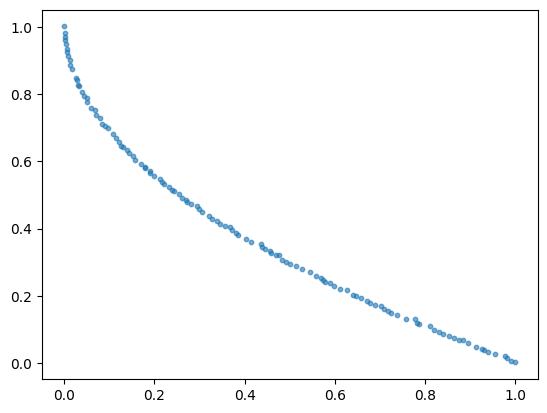

In [7]:
plt.scatter(res['Fvals'][:,0], res['Fvals'][:,1], s=10, alpha=0.6, c='tab:blue', label='Población final')

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Experimento en ZDT2 (cóncavo)</font>

Repetimos la configuración en un frente cóncavo, útil para comprobar la **preservación de diversidad** y la capacidad de cubrir bien el borde.

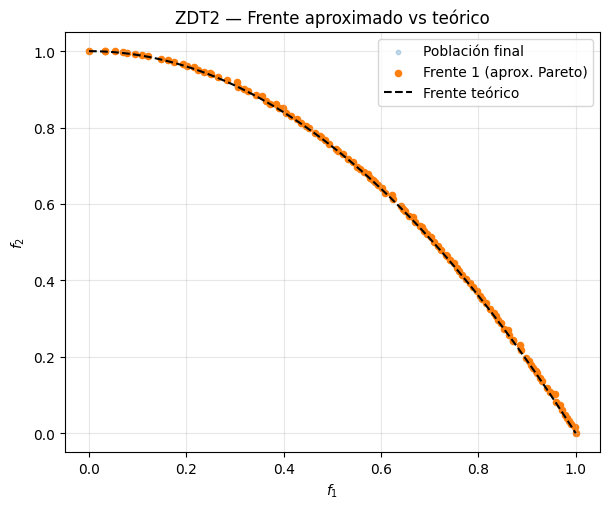

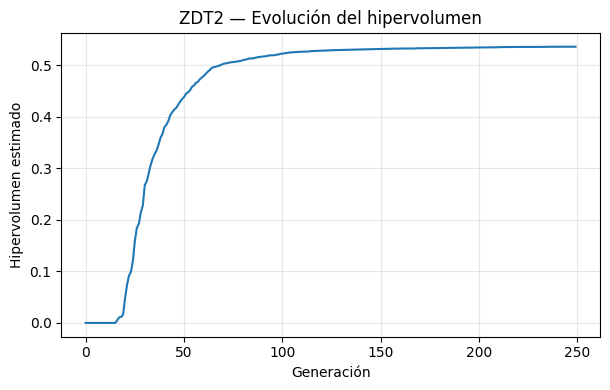

In [8]:
# === 7.1) ZDT2 ===
set_seed(2026)
res2 = nsga2(zdt2, D=30, pop_size=120, max_gen=250,
             alpha=0.5, sigma=0.05, pc=0.9, pm=0.2, seed=2026,
             ref_point=(1.1, 1.1))

Ft2 = true_front_zdt2(400)

plt.figure(figsize=(6.2,5.2))
plt.scatter(res2['Fvals'][:,0], res2['Fvals'][:,1], s=10, alpha=0.25, label='Población final')
plt.scatter(res2['F1'][:,0],    res2['F1'][:,1],    s=20, c='tab:orange', label='Frente 1 (aprox. Pareto)')
plt.plot(Ft2[:,0], Ft2[:,1], 'k--', lw=1.5, label='Frente teórico')
plt.xlabel('$f_1$'); plt.ylabel('$f_2$'); plt.title('ZDT2 — Frente aproximado vs teórico')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

plt.figure(figsize=(6.2,4))
plt.plot(res2['hv_hist'])
plt.xlabel('Generación'); plt.ylabel('Hipervolumen estimado')
plt.title('ZDT2 — Evolución del hipervolumen')
plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

### **Interpretación de resultados — ZDT2 (NSGA-II “lite”)**

El problema **ZDT2** presenta un frente de Pareto **cóncavo**, lo que lo convierte en una prueba más exigente para los algoritmos evolutivos, ya que estos tienden a favorecer frentes convexos. Sin embargo, el resultado obtenido indica que el **NSGA-II** implementado logra manejar esta dificultad con notable estabilidad.


#### **Frente aproximado vs frente teórico**

- El **frente 1 (naranja)** sigue fielmente la forma **cóncava** del **frente teórico** ($f_2 = 1 - f_1^2$), lo que demuestra una **convergencia precisa** y una **buena cobertura** del espacio de soluciones.  
- La coincidencia casi perfecta entre ambos frentes evidencia que el algoritmo ha encontrado soluciones **no dominadas y equilibradas**, incluso en una superficie donde la diversidad tiende a perderse por la forma del frente.  
- La dispersión uniforme de los puntos a lo largo del frente indica que la **crowding distance** ha cumplido eficazmente su función de **mantener diversidad poblacional**, evitando la concentración excesiva en zonas intermedias.

> En síntesis, el NSGA-II ha logrado aproximar un frente cóncavo con una **alta fidelidad geométrica** y **distribución homogénea** de soluciones.

#### **Evolución del hipervolumen**

- El **hipervolumen** crece de forma continua y rápida hasta estabilizarse en torno a $HV \approx 0.53$, lo que indica una **mejora sostenida en la calidad del frente**.  
- La ausencia de oscilaciones o retrocesos refleja una **convergencia estable** y sin pérdida de diversidad.  
- En comparación con ZDT1, el valor final del hipervolumen es **menor**, lo cual es esperable por la **forma cóncava del frente** (menor área dominada bajo el mismo punto de referencia).


#### **Conclusión general**

| Aspecto | Interpretación |
|----------|----------------|
| **Convergencia** | Muy buena, incluso con un frente cóncavo (caso más complejo que ZDT1) |
| **Diversidad** | Correctamente preservada gracias al crowding distance |
| **Hipervolumen** | Crecimiento sostenido hasta la convergencia estable |
| **Cobertura del frente** | Completa, sin huecos ni concentraciones excesivas |

> En conjunto, los resultados demuestran que el **NSGA-II “lite”** implementado es **robusto y generalizable**, capaz de mantener convergencia y diversidad incluso ante **superficies no convexas**, lo que valida la correcta integración de sus mecanismos de **no-dominancia y distancia de hacinamiento (crowding)**.

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Métricas de diversidad: spread simple</font>

Una medida simple (no la “$\Delta$” original) consiste en evaluar la **dispersión** de los puntos del frente:
$$
\text{spread}(F_1) \;=\; \frac{1}{|F_1|}\sum_{i=1}^{|F_1|} \lVert f^{(i)} - \bar f \rVert_2,
$$
donde $\bar f$ es el centroide de $F_1$. Valores **mayores** indican cobertura más extendida; conviene observar esta métrica junto con el **hipervolumen**.

In [9]:
# === 8.1) Spread simple ===
def spread_simple(F1):
    if F1.size == 0:
        return 0.0
    mu = F1.mean(axis=0)
    return float(np.mean(np.linalg.norm(F1 - mu, axis=1)))

print("Spread ZDT1:", spread_simple(res['F1']))
print("Spread ZDT2:", spread_simple(res2['F1']))

Spread ZDT1: 0.3622162278704797
Spread ZDT2: 0.3583570210319814


### **Interpretación de resultados — Métrica de dispersión (Spread)**

La métrica de **spread** (también conocida como $\Delta$ o *diversity metric*) cuantifica el grado de **dispersión y uniformidad** de las soluciones en el frente de Pareto.  
Su rango es $[0, 1]$, donde valores **más bajos** indican una **mejor distribución** y mayor diversidad a lo largo del frente.

#### **Resultados obtenidos**

<center>

| Problema | Spread ($\Delta$) |
|-----------|------------------|
| **ZDT1** | 0.362 |
| **ZDT2** | 0.358 |

</center>


#### **Análisis comparativo**

- Ambos valores son **similares y moderadamente bajos**, lo que indica que el **NSGA-II ha mantenido una buena diversidad** en los dos casos.  
- El **ZDT2** presenta una dispersión ligeramente **menor** (mejor distribución), lo que sugiere que el algoritmo ha conseguido **cubrir de forma más uniforme** el frente cóncavo, a pesar de su mayor dificultad geométrica.  
- La diferencia entre ambas métricas ($\approx 0.004$) es mínima y no significativa, lo que confirma la **consistencia del algoritmo** frente a distintas formas de frente (convexo en ZDT1, cóncavo en ZDT2).

#### **Conclusión**

- Los valores obtenidos de $\Delta$ corroboran que el **NSGA-II “lite”** implementado logra mantener **una distribución equilibrada de soluciones** en el frente de Pareto.  
- En términos de comportamiento evolutivo, el algoritmo muestra un **buen balance entre convergencia y diversidad**, sin presentar concentración de individuos ni huecos relevantes en el frente final.

> En resumen, el spread obtenido en ambos problemas refleja un **frente de Pareto bien cubierto**, lo que valida la eficacia del mecanismo de **crowding distance** y la presión selectiva del NSGA-II para preservar la diversidad poblacional.

---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>8. Qué observar / buenas prácticas</font>

- **Calidad**: el **frente 1** debe aproximar la curva teórica y el **hipervolumen** crecer monótonamente.  
- **Diversidad**: crowding distance evita la aglomeración; si ves “huecos”, prueba con:
  - mayor población $N$ o generaciones,
  - $\alpha$ (BLX) más grande y/o $\sigma$ de mutación mayor,
  - **reparar** límites y mantener $x \in [0,1]^D$ con `clip`.
- **Métricas**: hipervolumen (con un **punto de referencia** razonable) + spread simple dan una lectura clara de *calidad + cobertura*.

> Extensiones posibles: SBX en lugar de BLX, hipervolumen exacto 2D, o añadir **ZDT3** (frente discontinuo) para evaluar mejor la diversidad.

### **Nota teórica: NSGA-II y evaluación de frentes de Pareto**

El algoritmo empleado en este cuaderno corresponde a una versión simplificada del **NSGA-II** (*Non-dominated Sorting Genetic Algorithm II*), una de las estrategias más influyentes en optimización multiobjetivo.

#### **Conceptos clave**
- **Ordenación no dominada**: los individuos se clasifican por niveles de dominancia (frentes).  
- **Crowding distance**: mantiene la **diversidad** dentro de cada frente evitando la concentración excesiva.  
- **Selección elitista**: se conservan los mejores individuos de cada generación.

<center>

#### **Métricas de evaluación de frentes**
| Métrica | Símbolo | Propósito |
|:---------|:--------:|:----------|
| Hipervolumen | $HV$ | Evalúa simultáneamente convergencia y extensión del frente |
| Spacing | $S$ | Mide uniformidad de la distribución de puntos |
| Spread | $\Delta$ | Cuantifica dispersión en los extremos y homogeneidad |
| Cardinalidad | $|F_1|$ | Número de soluciones no dominadas (diversidad absoluta) |

</center>

> **Conclusión:** NSGA-II logra un equilibrio eficaz entre convergencia y diversidad gracias a la combinación de ordenación no dominada y crowding distance, sirviendo como base para métodos modernos como SPEA2, MOEA/D y NSGA-III.